In [1]:
#Importation des différentes fonctions qui servent dans ce script

import sys

sys.path.append("Users\smoot\Desktop\Stage Mnemosyne\functions")
sys.path.append("Users\smoot\Desktop\Stage Mnemosyne\experience")
sys.path.append("C:\\Users\\smoot\\Desktop\\Stage Mnemosyne")

import functions.functions_data as d
import functions.functions_affichage as a
import functions.functions_cocleogramme as c
from functions.ReccurentNetwork import RecurrentNetwork

from random import randint

from IPython.display import clear_output

from reservoirpy.mat_gen import Initializer,_scale_spectral_radius,normal
from reservoirpy.observables import spectral_radius
from tqdm import tqdm

from ReccurentNetwork import *

import numpy as np
import copy
from numpy.linalg import eig

import spicy as sp
import matplotlib.pyplot as plt


# Réseaux de neurones

Les mesures de l'article sont effectuées sur 2 réservoirs  : 

  - le premier est dit entrainé : on va alors entrainer le réservoir et la sortie
  - le second lui est dit non entrainé : on entraine seulement la sortie

## Expériences

Deux expériences quasiment similaires sont proposés pour un réservoir totalement entrainé. La seule différence entre ces dernières sont le nombre de neurones utilisés dans le réservoir : 

   - Soit N = 2100 pour des résultats robustes entre toutes les données pour un sujet
   - Soit N = 4000 pour des résultats robustes entre tous les sujets (5 au maximum)
    
Nous traiterons le premier  cas dans ce papier.

##### Méthode d'entrainement

Pour ce qui est de l'entrainement du réservoir nous allons procéder comme ceci :

Pour un sujet donné et parmit toutes les entrées différentes, pour chaque chiffre on selectionne l'entrée maximale. Cette entrée est injectée dans le réservoir sans bruit et sans target, on obtient alors une trajectoire resultante de taille (Timesteps x Nombre de neurones) pour chaque chiffre. Ces 10 trajectoires sont appelées les "innate trajectories" et seront les targets pour toutes les autres entrées durant l'entrainement en faisant bien attention à  ce que la dimension d'entrée des nouvelles entrées soit cohérente avec celle de l'innate trajectorie, on rajoutera donc à la fin des époques sensorielles trop courtes des 0. De plus, du bruit sera présent durant l'entrainement.


###### Test
Les test effectués dans ce script seront fait sur le sujet 1

Données générales 

In [2]:
data = d.extract_data() #Données d'entrée
transcription = d.extract_target() #Données d'arrivée 

#Les données suivantes sont utilisés dans les fonctions mais pas dans le script ! 

freq_ent = 6*10**3  #fréquence d'entrée
T_ent = 1/freq_ent  #période d'entrée

freq_out = 10**3 #fréquence de sortie 
T_out = 1/freq_out #période de sortie

ampl_int = 5 #Amplitude d'entrée

Données du réservoir

In [3]:
N = 2100//10 #Nombre de neurones dans le réservoir
M = 12 #Nombres d'entrées
No = 3 #Nombres de sorties
tau = 25*10e-3
dt = 1e-3
lr = dt/tau
sr = 1.6 #spectral radius --> gain ?
g = 1.6 #le gain du réseau ?                             #je comprends pas trop cette donnée. 
pc = 0.2 # connectivité entre les neurones (pc dans l'article)
SD = g/np.sqrt(pc*N)
mu = 0
I0 = 0.005
biais = 0.25

Wout = normal(No,N,loc=mu,scale = 1/np.sqrt(N))    #Matrice de sortie

enregistrement = True #Est ce que on veut créer des seeds 

Création de la matrice du réservoir : avec pas d'autapse
Puis bricolage pour réxupérer le rayon spectral voulu

In [4]:
#Création de la matrice d'entrée
c.W_r.init = Initializer(c.W_r)

#On ajuste le rayon spectral
W = _scale_spectral_radius(c.W_r.init, [N,N], sr)

W = W.toarray()

Création de la matrice d'entrée : chaque entrée k est projetée sur le neurone $(k-1)\frac{N}{M} + 1$ jusqu'au neurone $k\frac{N}{M}$ selon une loi normale 

In [5]:
Win = c.W_in(N,M)

Création des réservoirs

# Test RLS avec code de Vitay

Problème :
  - déformation linéaire : ça met les valeurs de mes trajectoires innées au dessus de un et en dessous de -1 
  - entrainement du RLS s'arrete quand l'erreur tend asymptotiquement vers une valeur 

In [6]:

Wrec = copy.deepcopy(W)
I0 = 0.05

net = RecurrentNetwork(
    W_in = Win,
    W_rec = Wrec,
    W_out = Wout,
    Ni = M, # Number of inputs
    N = N, # Number of recurrent neurons
    No = No, # Number of read-out neurons
    tau = 25.0, # Time constant of the neurons
    g = 1.6, # Synaptic strength scaling
    pc = 0.2, # Connection probability
    Io = I0, # Noise variance
    delta = 1, # Initial diagonal value of the P matrix
    P_plastic = 0.9, # Percentage of neurons receiving plastic synapses
)

In [7]:
#Liste qui va contenir tout les cocleogramme maximums pour chaque chiffre
max_cocleogram =[]

for i in range(10):
    
    #Récupération des indices du cocléogramme le plus grand du chiffre i
    indS,indU,indD = c.ind_max_entrance(i,data)
    
    #Ajout à la liste
    max_cocleogram.append(c.entrance_cocleogram(indS,indS,indD,data,transcription,biais).T)

In [8]:

#Liste qui va contenir toutes les trajectoires innees
innate_trajectories = []

for i in range(len(max_cocleogram)):
    
    #Recuperation de la donnee qu'on va mettre dans le reservoir
    stimulus = np.expand_dims(max_cocleogram[i],axis =2)
    
    #On genere la trajectoire inee et on la garde 
    initial_trajectory, _, = net.simulate(stimulus = stimulus, noise = False)
    
    #Ensuite on l'ajoute a la liste
    innate_trajectories.append(initial_trajectory)

clear_output()

Affichage de quelques neurones durant la trajectoire innée 

trajectoire innée affichée :  3


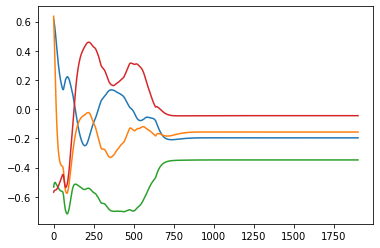

In [9]:
alea = randint(0,9)
affichage_innate = np.squeeze(innate_trajectories[alea],axis =2)
plt.plot(affichage_innate[:,:4])
clear_output()
print("trajectoire innée affichée : ",alea)

affichage des tout les neurones durant une trajectoire innée 

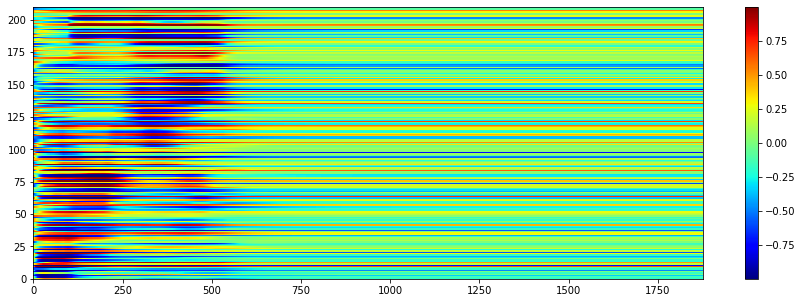

In [10]:
state_network = np.squeeze(innate_trajectories[0],axis =2 )
fig, ax = plt.subplots(figsize=(15,5))
im = ax.pcolormesh(state_network.T ,cmap="jet")
fig.colorbar(im,ax = ax)

In [11]:
####################
# Données entrainement
####################

X_input_rc = []
X_target_rc = []
for indS in [1] : 
    for indU in range(1,6):
        for indD in range(10):
            #Récupération de l'Input
            Input = np.expand_dims(c.entrance_cocleogram(indS, indU, indD,data,transcription,biais).T,axis =2)
            
            #Ajout
            X_input_rc.append(Input)
            
            #Récupération de la target
            target = innate_trajectories[indD] 

            #Ajout dans la target
            X_target_rc.append(target)
    
            

Récupération des états pre training

In [12]:
pre_training,_ = net.simulate(stimulus = X_input_rc[0])

pre_training = np.squeeze(pre_training,axis = 2)

pre_training_target = X_target_rc[0]


100%|███████████████████████████████████████████████████████████████████████████| 1876/1876 [00:00<00:00, 17151.55it/s]


Affichage des tout les états initiaux du réseau

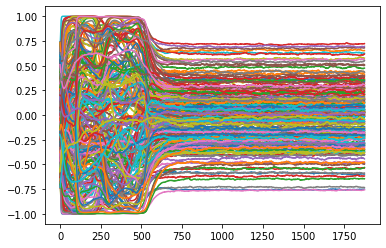

In [13]:
plt.plot(pre_training)
clear_output()

In [14]:
####################
# Training reccurent weight
####################

nb_learning_trials_rec = 0 #Compte le nombre d'entraînement
epsilon = 0.01 #Epsilon classique, sert pour la convergence
error_total=[] #Liste qui contient l'évolution de l'erreur
e = 1 #Initialisation de l'erreur
mean_error = 0 #Initialisation de la moyenne de l'erreur

while nb_learning_trials_rec < len(X_input_rc)*2 or e < mean_error-epsilon or e > mean_error+epsilon:
    
    #i varie entre 0 et la taille de X_input_rc
    i = nb_learning_trials_rec % len(X_input_rc)
    
    #On définit l'entrée qu'on va mettre dans le réservoir
    impulse = X_input_rc[i]
    
    #On définit la trajectoire cible
    target_rc = X_target_rc[i]
    
    #On définit quand l'apprentissage ce termine
    stop = np.shape(X_input_rc[i])[0]
    
    #On fait tourner le réservoir et on récupère l'erreur
    _, _, e = net.simulate(stimulus=impulse,
                        trajectory=target_rc,
                        learn_start= 0,
                        learn_stop=stop,
                        value_loss = True)
    
    #On ajoute l'erreur à la liste
    error_total.append(e)
    
    #On calcule la moyenne
    mean_error = np.mean(error_total)
    
    #Le compteur augment de 1 
    nb_learning_trials_rec += 1
    
    clear_output()
    
    print('Entrainement numéro : ', nb_learning_trials_rec,'erreur : ',e,"moyenne des erreurs : ",mean_error)
    
    """
    Enregistrement des seeds en cours d'entraînement et test du réseau avec enregistrement des graphes.
    """
    
    if i%len(X_input_rc) == 0 and enregistrement == True:
        
        print("Début enregistrement")
        
        W_train = getattr(net,"W_rec")
        
        entrance_matrice = [Win,W,Wout]
        trained_matrice = [W_train,Wout]

        chemin = 'C:/Users/smoot/Desktop/Stage Mnemosyne/experience'

        name, namefile = d.save_seed(entrance_matrice,
                                  trained_matrice,
                                  chemin = chemin,
                                  N = N,
                                  sr = sr,
                                  biais = biais,
                                  I0 = I0,
                                  nb_learning_trials_rec=nb_learning_trials_rec,
                                  nb_learning_trials_readout=0,
                                  code = "Vitay",
                                  meanerror = mean_error,
                                  entraînement = "Entraînement de la matrice W")

        a.eigein_value(W_train,"W_train",W,"W",filename = namefile)
        
        post_training, _ = net.simulate(stimulus = X_input_rc[0])

        post_training = np.squeeze(post_training,axis =2)
        
        a.pre_post_affichage(N,pre_training,pre_training_target,post_training,filename = namefile)
        
        

Entrainement numéro :  100 erreur :  0.007309717144870942 moyenne des erreurs :  0.009590829006478728


Affichage de l'erreur 

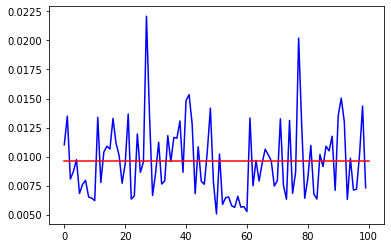

In [15]:
plt.plot(error_total,"b")
plt.plot([0,len(error_total)],[mean_error,mean_error],"-r")

Récupération des données après entrainement et affichage

100%|███████████████████████████████████████████████████████████████████████████| 1876/1876 [00:00<00:00, 13698.50it/s]
C:\Users\smoot\Desktop\Stage Mnemosyne\functions\functions_affichage.py:303: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


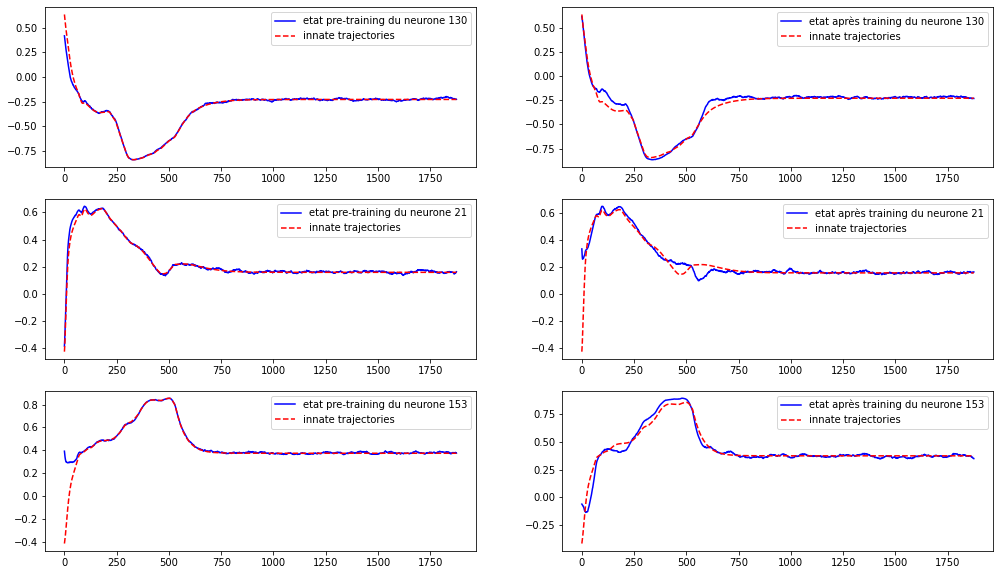

In [16]:
post_training, _ = net.simulate(stimulus = X_input_rc[0])

post_training = np.squeeze(post_training,axis =2)

a.pre_post_affichage(N,pre_training,pre_training_target,post_training)

Affichage des valeurs propres

C:\Users\smoot\Desktop\Stage Mnemosyne\functions\functions_affichage.py:283: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


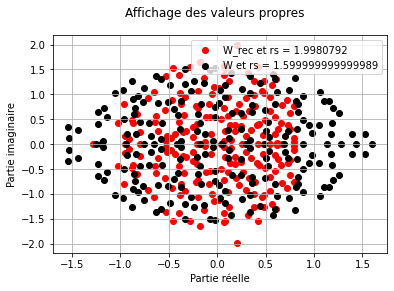

In [17]:
W_train = getattr(net,"W_rec")
a.eigein_value(W_train,"W_rec",W,"W",filename = False)

# Entrainement de la sortie

Récupération des données 

In [18]:
X_input_out = []
X_target_out = []
for indS in [1] : 
    for indU in range(1,6):
        for indD in range(10):
            #ajout de l'input
            input_out = np.expand_dims(np.transpose(c.entrance_cocleogram(indS, indU, indD,data,transcription,biais)),axis = 2)
            
            X_input_out.append(input_out)
            
            #ajout de la target
            target_out = np.expand_dims(c.target_xyz(indS, indU, indD,data,transcription),axis =2)
            
            X_target_out.append(target_out)
            

Entrainement

In [19]:
####################
# Training output weight
####################

nb_learning_trials_readout = len(X_input_out)*5


for i in tqdm(range(nb_learning_trials_readout)):
    
    i = i % len(X_input_out)
    
    print('Learning trial readout', i+1)
    
    stop = np.shape(X_input_out[i])[0]
    
    impulse = X_input_out[i]
    
    target = X_target_out[i]
    
    _, _ = net.simulate(stimulus=impulse,
                        trajectory=target,
                        learn_start=0,
                        learn_stop=stop,
                        learn_readout=True)
    
    
    clear_output()
    
    """
    Enregistrement de la seed durant l'entraînement et test
    """
    
    if i%len(X_input_out) == 0 and enregistrement == True:
        
        print("Début enregistrement")
        
        Wout_train = getattr(net,"W_out")
        entrance_matrice = [Win,W,Wout]
        trained_matrice = [W_train,Wout_train]

        chemin = 'C:/Users/smoot/Desktop/Stage Mnemosyne/experience'

        name, namefile = d.save_seed(entrance_matrice,
                                  trained_matrice,
                                  chemin = chemin,
                                  N = N,
                                  sr = sr,
                                  biais = biais,
                                  I0 = I0,
                                  nb_learning_trials_rec=nb_learning_trials_rec,
                                  nb_learning_trials_readout=nb_learning_trials_readout,
                                  code = "Vitay",
                                  entrainement = "L'entrainement a été effectué sur le sujet 1 et parmis les entrées 1 à 5")

        a.eigein_value(W_train,"W_train",W,"W",filename = namefile)
        a.pre_post_affichage(N,pre_training,pre_training_target,post_training,filename = namefile)
        
        #Test du réservoir

        #Récupération d'un cocléogramme utilisé durant l'entrainement
        indS,indU,indD = 1,randint(1,5),randint(0,9)
        X_test = np.transpose(c.entrance_cocleogram(indS,indU,indD,data,transcription,biais))
        X_test = np.expand_dims(X_test,axis =2)


        #On fait trner le réservoir
        X_state,X_output = net.simulate(stimulus = X_test)

        X_state = np.squeeze(X_state,axis =2)
        X_output = np.squeeze(X_output,axis =2)

        #récupération de l'erreur commise sur la trajectoire d'un chiffre
        erreur= c.error(X_output,indS,indU,indD,data,transcription)
        
        a.affiche(X_output,indS,indU,indD,data,transcription,biais,X_state,erreur,mode = "online",filename = namefile,sr = sr,N=N,I0 =I0 )
        
        #Récupération de l'entrée et du sujet
        indS,indU= 1,randint(1,5)

        chiffre_pred_rc=[]

        #On calcule la prédictions pour chacun des 10 chiffres 
        for i in range(10):
    
            #Récupération de l'entrée
            X_test_rc = np.expand_dims(c.entrance_cocleogram(indS,indU,i,data,transcription,biais).T,axis=2)
    
            #On fait tourner le réservoir
            _,X_output = net.simulate(X_test_rc)
    
            X_output = np.squeeze(X_output,axis =2)
    
            #On ajoute à la liste
            chiffre_pred_rc.append(X_output)
        
        a.affiche_chiffre(chiffre_pred_rc,indS,indU,data,transcription,mode="online",filename =namefile,sr = sr,N=N,I0 = I0,biais=biais)
        
        clear_output()

100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [04:13<00:00,  1.02s/it]


Test du réservoir 

In [20]:
#Test du réservoir

#Récupération d'un cocléogramme utilisé durant l'entrainement
indS,indU,indD = 1,3,6
X_test = np.transpose(c.entrance_cocleogram(indS,indU,indD,data,transcription,biais))
X_test = np.expand_dims(X_test,axis =2)


#On fait trner le réservoir
X_state,X_output = net.simulate(stimulus = X_test)

X_state = np.squeeze(X_state,axis =2)
X_output = np.squeeze(X_output,axis =2)

#récupération de l'erreur commise sur la trajectoire d'un chiffre
erreur= c.error(X_output,indS,indU,indD,data,transcription)


100%|███████████████████████████████████████████████████████████████████████████| 2049/2049 [00:00<00:00, 15004.79it/s]


C:\Users\smoot\Desktop\Stage Mnemosyne\functions\functions_affichage.py:172: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


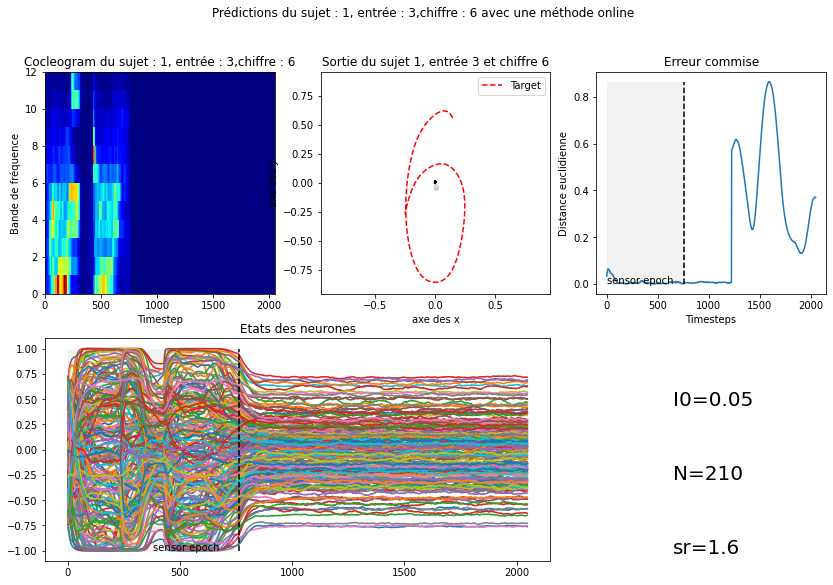

In [21]:
a.affiche(X_output,indS,indU,indD,data,transcription,biais,X_state,erreur,mode = "online",sr = sr,N=N,I0 =I0 )

Affichage pour plusieurs chiffres

In [22]:
#Récupération de l'entrée et du sujet
indS,indU= 1,3

chiffre_pred_rc=[]

#On calcule la prédictions pour chacun des 10 chiffres 
for i in range(10):
    
    #Récupération de l'entrée
    X_test_rc = np.expand_dims(c.entrance_cocleogram(indS,indU,i,data,transcription,biais).T,axis=2)
    
    #On fait tourner le réservoir
    _,X_output = net.simulate(X_test_rc)
    
    X_output = np.squeeze(X_output,axis =2)
    
    #On ajoute à la liste
    chiffre_pred_rc.append(X_output)


100%|███████████████████████████████████████████████████████████████████████████| 1914/1914 [00:00<00:00, 14852.34it/s]


C:\Users\smoot\Desktop\Stage Mnemosyne\functions\functions_affichage.py:237: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


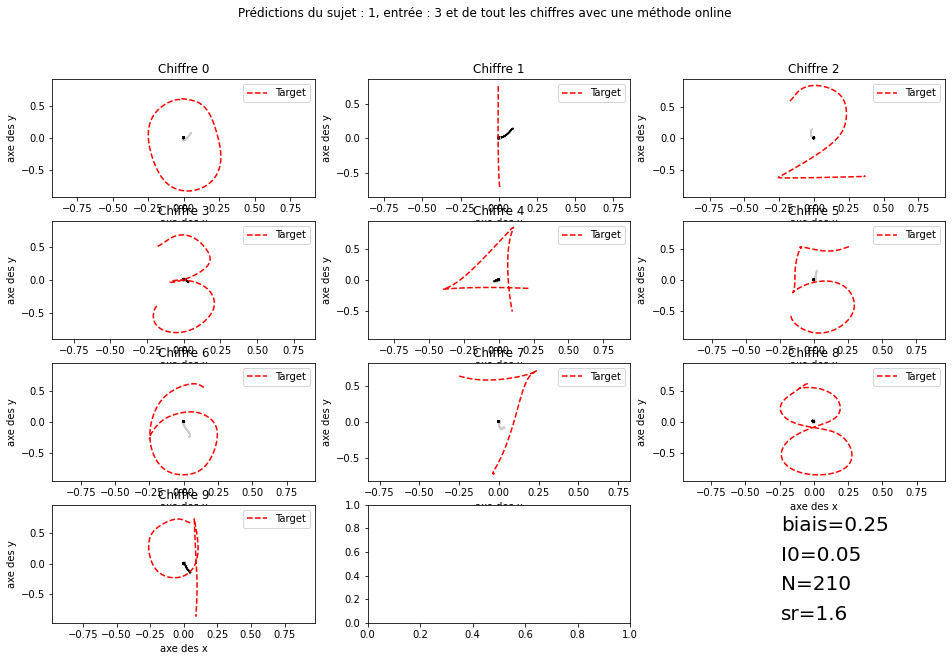

In [23]:
a.affiche_chiffre(chiffre_pred_rc,indS,indU,data,transcription,mode="online",sr = sr,N=N,I0 = I0,biais=biais)

## Sauvegarde de la seed finale

In [24]:
entrance_matrice = [Win,W,Wout]
trained_matrice = [W_train,Wout_train]

chemin = 'C:/Users/smoot/Desktop/Stage Mnemosyne/experience'

name, namefile = d.save_seed(entrance_matrice,
                                  trained_matrice,
                                  chemin = chemin,
                                  N = N,
                                  sr = sr,
                                  biais = biais,
                                  I0 = I0,
                                  nb_learning_trials_rec=nb_learning_trials_rec,
                                  nb_learning_trials_readout=nb_learning_trials_readout,
                                  code = "Vitay")

a.eigein_value(W_train,"W_train",W,"W",filename = namefile)
a.pre_post_affichage(N,pre_training,pre_training_target,post_training,filename = namefile)
a.affiche(X_output,1,3,6,data,transcription,biais,X_state,erreur,mode = "online",filename = namefile,sr = sr,N=N,I0 =I0 )
a.affiche_chiffre(chiffre_pred_rc,indS,indU,data,transcription,mode="online",filename =namefile,sr = sr,N=N,I0 = I0,biais=biais)

Fichier sauvegardé
